# Project : INTRODUCTION TO MACHINE LEARNING

## Imports

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
import math 
import random 
import matplotlib.pyplot as plt 
import heapq

## Chargement des données

In [42]:
dataset = pd.read_csv("waveform.data.csv", sep=',', header=None)

dataset_shuffle = dataset.sample(frac=1.0, random_state=42)

X = dataset_shuffle.iloc[:, :-1]
y = dataset_shuffle.iloc[:, -1]


## k-NN

In [43]:

X_train = X.iloc[:4000]
y_train = y.iloc[:4000]

X_test = X.iloc[4000:]
y_test = y.iloc[4000:]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [68]:

def distance_euclidienne(point1, point2):
    """
    Calcule la distance euclidienne entre deux points.
    """
    somme_carres = 0.0
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        somme_carres += difference ** 2
    return somme_carres ** 0.5

def knn_algorithm(x, k, metrique, X_train, y_train):
    """
    Prédit la classe d'un point x en utilisant l'algorithme k-NN.
    """
    list_distances = []
    
    # Convertir x en tableau numpy 2D pour cdist
    x_2d = np.array(x).reshape(1, -1)
    
    for i in range(len(X_train)):
        # dist = distance_euclidienne(x, X_train.iloc[i].values)
        
        # Méthode 2 : Avec cdist (plus rapide)
        point_2d = np.array(X_train.iloc[i]).reshape(1, -1)
        dist = cdist(x_2d, point_2d, metric=metrique)[0][0]
        
        list_distances.append((dist, i))

    list_distances.sort(key=lambda x: x[0])  # Trie par distance

    k_nearest_neighbors = list_distances[:k]
    votes = {}
    
    for dist, index in k_nearest_neighbors:
        label = y_train.iloc[index]
        votes[label] = votes.get(label,0) + 1

    return max(votes, key=votes.get)


""" Optimisation KNN en vectorisant nos données et en effectuant les 4 millions de calculs de distance en seulement une opération avec Numpy """

def knn_algorithm_vectorise(x, k, metrique, X_train, y_train):
    x_2d = np.array(x).reshape(1, -1)
    X_2d = np.array(X_train)
    
    distances = cdist(x_2d, X_2d, metric=metrique)[0]
    
    k_indices = np.argsort(distances)[:k]
    votes = y_train.iloc[k_indices].value_counts()
    return votes.idxmax()

def evaluer_modele(X_test, y_test, k, metrique, X_train, y_train):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(X_test)
    
    for i in range(total):
        point_test = X_test.iloc[i].values  # Convertir en numpy array
        vrai_label = y_test.iloc[i]
        
        # prediction = knn_algorithm(point_test, k, metrique, X_train, y_train)
        prediction = knn_algorithm_vectorise(point_test, k, metrique, X_train, y_train)
        if prediction == vrai_label.item():
            nombre_correct += 1
    
    return nombre_correct / total

def cross_validation_knn(X, y, k_values, n_folds=5, metric='euclidean'):
    """
    Cross-validation pour choisir le meilleur k

    Args:
        X: Features du dataset
        y: Labels du dataset complet
        k_values: Liste contenant les valeurs de k à tester
        n_folds: Nombre de folds
        metric: Métrique de distance

    Returns:
        best_k: Meilleure valeur de k
        best_accuracy: Meilleure précision moyenne
        results: Dictionnaire avec les résultats pour chaque k
    """
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = len(X) // n_folds
    indices = np.arange(len(X))
    
    # mélanger les indices pour des folds aléatoires
    np.random.shuffle(indices)
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        # créer des datasets pour ce fold
        X_train_fold = X.iloc[train_indices].reset_index(drop=True)
        y_train_fold = y.iloc[train_indices].reset_index(drop=True)
        X_val_fold = X.iloc[val_indices].reset_index(drop=True)
        y_val_fold = y.iloc[val_indices].reset_index(drop=True)
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_val_fold, y_val_fold, k, metric, X_train_fold, y_train_fold)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies
    

# Utilisation
def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


### Execution

~ 2-4 minutes

In [69]:
def main_knn():
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 51))
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5, metric='euclidean'
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)
    
    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_test, y_test, best_k, 'euclidean', X_train, y_train)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + " avec k k={best_k}")
    print(f"Bayes optimal: 86%")


Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 49, précision de 0.8598


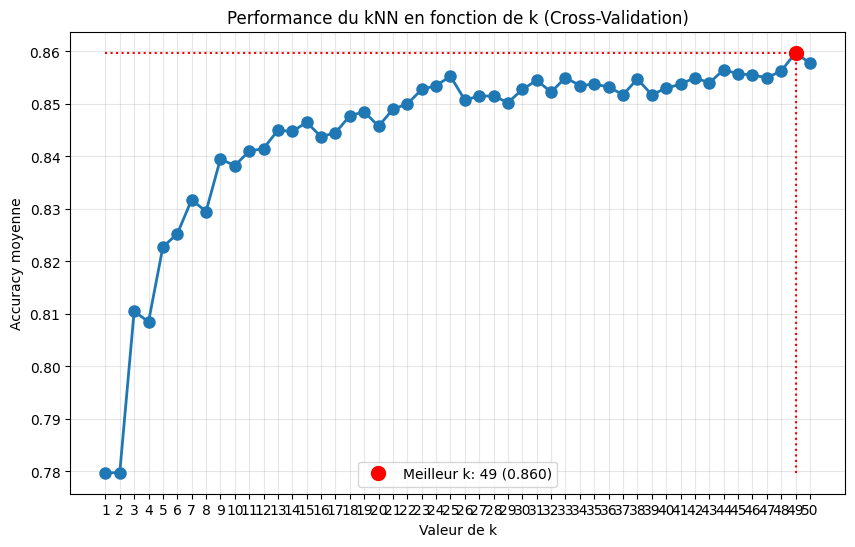

Accuracy finale sur le test set: 0.8600 (86.00%) avec k k={best_k}
Bayes optimal: 86%


In [44]:
main_knn()

### Test

In [ ]:
# Test
accuracy = evaluer_modele(X_test, y_test, 5, 'euclidean', X_train, y_train)
print(f"Avec k=5, accuracy = {accuracy:.3f} ({accuracy*100:.1f}%)")

## Data reduction

In [64]:
def distance(v1,v2):
    """
    Renvoie la distance euclidiennes entre les vecteurs v1 et v2
    """
    somme = 0. 
    for x, y in zip(v1, v2):
        somme += (x - y) ** 2
    return math.sqrt(somme)

def un_NN(p, X, y): # TODO à optimiser en se servant des distances déjà calculées pour le k-NN 
    """
    1-NN 

    Args:
        p: Point à tester
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        label: label du point le plus proche 
    """

    # Initialisation 
    # dmin = distance(p, X[0])
    dmin = cdist(p.reshape(1, -1), X[0].reshape(1, -1), metric="euclidean")[0][0]
    label = y[0]

    for i in range(1, X.shape[0]):
        #d = distance(p, X[i])
        d = cdist(p.reshape(1, -1), X[i].reshape(1, -1), metric="euclidean")[0][0]
        if d < dmin: # si on trouve un point plus proche 
            dmin = d
            label = y[i]
    
    return label

def sep_data(X, y):
    """
    Mélange et sépare les données 

    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        l_id: Liste d'indices 
        milieu: indice du milieu
    """
    l_id = [i for i in range(X.shape[0])]
    random.shuffle(l_id)
    milieu = len(l_id) // 2
    return (l_id, milieu)

def reduction1(X, y):
    """
    1ère algorithme de réduction du dataset vu en cours 
    Suppression de la zone de biais 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Split randomly S into two subsets S1 and S2;
    (ordre, milieu) = sep_data(X, y)
    S1_X, S1_y = X[ordre[:milieu]], y[ordre[:milieu]]
    S2_X, S2_y = X[ordre[milieu:]], y[ordre[milieu:]]

    ch = True 
    while (ch): # Tant qu'il y a un changement S1 et S2 ne sont pas stabilisées 
        ch = False

        # Classify S1 with S2 using the 1-NN rule;
        # Remove from S1 the misclassified instances;
        nv_S1_X = []
        nv_S1_y = []
        for xi, yi in zip(S1_X, S1_y):
            l = un_NN(xi, S2_X, S2_y)
            if l == yi: 
                nv_S1_X.append(xi)
                nv_S1_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S1_X = np.array(nv_S1_X)
        S1_y = np.array(nv_S1_y)

        # Classify S2 with the new set S1 using the 1-NN rule;
        # Remove from S2 the misclassified instances;
        nv_S2_X = []
        nv_S2_y = []
        for xi, yi in zip(S2_X, S2_y):
            l = un_NN(xi, S1_X, S1_y)
            if l == yi: 
                nv_S2_X.append(xi)
                nv_S2_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S2_X = np.array(nv_S2_X)
        S2_y = np.array(nv_S2_y)
    
    # Union de S1 et S2 
    X_cleaned = np.concatenate((S1_X, S2_X), axis=0)
    y_cleaned = np.concatenate((S1_y, S2_y))
    
    return (X_cleaned, y_cleaned)

def reduction2(X, y):
    """
    2ème algorithme de réduction du dataset vu en cours 
    Suppression des données non pertinentes 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Initialisation
    STORAGE_X = []
    STORAGE_y = []
    DUSTBIN_X = []
    DUSTBIN_y = []

    # Draw randomly a training example from S and put it in STORAGE;
    idx0 = random.randint(0, X.shape[0] - 1)
    STORAGE_X.append(X[idx0])
    STORAGE_y.append(y[idx0])

    ch = True
    while (ch): # Tant que STORAGE n'est pas stabilisé 
        ch = False
        
        for xi, yi in zip(X, y):

            # Ne pas traiter un point déjà dans STORAGE 
            liste_STORAGE_X = [p.tolist() for p in STORAGE_X]
            if xi.tolist() in liste_STORAGE_X:
                continue

            l = un_NN(xi, np.array(STORAGE_X), np.array(STORAGE_y))

            if l == yi: # if xi is correctly classified with STORAGE using the 1-NN rule
                # bien classé -> poubelle (inutile)
                DUSTBIN_X.append(xi)
                DUSTBIN_y.append(yi)
            else:
                # mal classé -> stockage (utile)
                STORAGE_X.append(xi)
                STORAGE_y.append(yi)
                ch = True

    return (np.array(STORAGE_X), np.array(STORAGE_y))


### PCA

In [4]:
def pca(X, y, titre):
    """
    PCA
    
    Args:
        X: Features du dataset
        y: Labels du dataset 
    
    """

    X_pca = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)

    labels = X_pca[:, -1].astype(int)
    X_features = X_pca[:, :-1]

    # Centrer les données (features)
    X_meaned = X_features - np.mean(X_features, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    # Valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    # Tri décroissant
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_index]

    # Projection sur les 2 premiers vecteurs propres
    eigenvector_subset = sorted_eigenvectors[:, 0:2]
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # Affichage avec couleur par label
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap='viridis', edgecolor='k')

    # Ajouter une légende
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(titre)
    plt.grid(True)
    plt.show()

### Avant réduction 

In [5]:
# Les fonctions de réductions prennent des tableau numpy 
X_np = X.to_numpy()
y_np = y.to_numpy()

### 1ère réduction 

~ 5-8 minutes

Passe de 5000 lignes à environ 4000

In [6]:
(X_cleaned, y_cleaned) = reduction1(X_np, y_np) 
print(X.shape, "-> X_cleaned :", X_cleaned.shape)

(5000, 21) -> X_cleaned : (4006, 21)


### 2ème réduction

~ 2-4 minutes

Passe de ~4000 lignes à ~800-900 lignes 

In [47]:
(X_cleaned2, y_cleaned2) = reduction2(X_cleaned, y_cleaned)
print(X_cleaned.shape, "-> X_cleaned2 :", X_cleaned2.shape)

(4006, 21) -> X_cleaned2 : (850, 21)


## Affichage

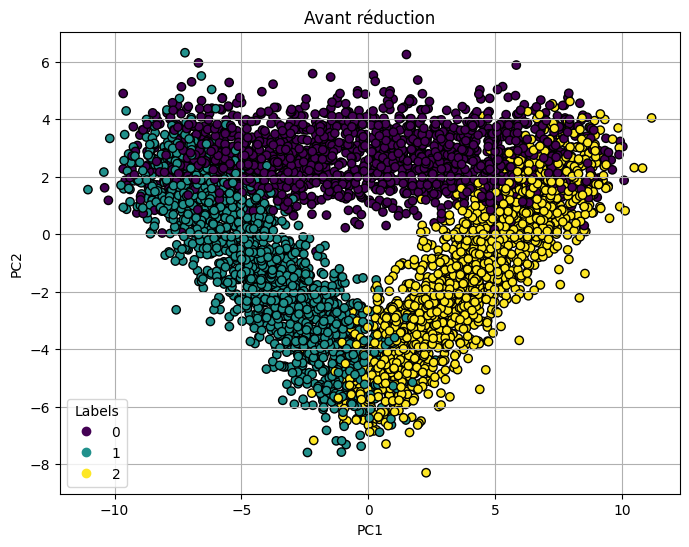

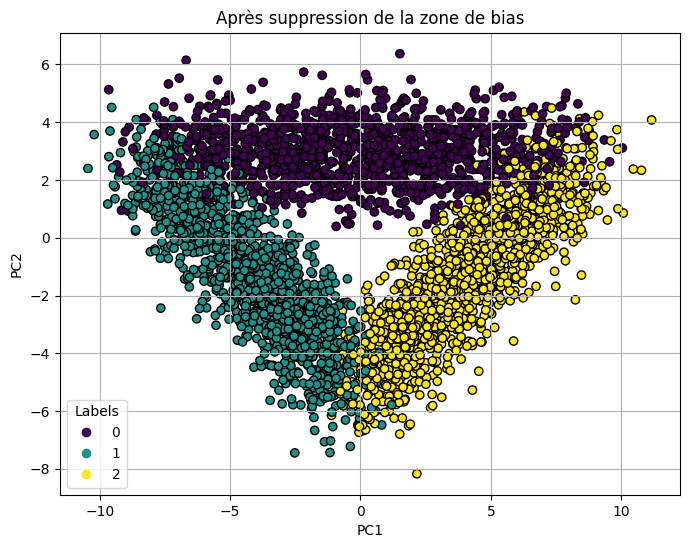

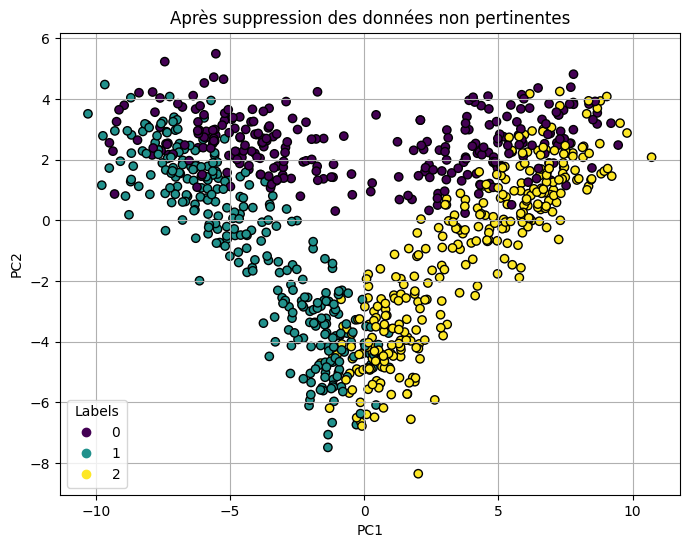

In [8]:
pca(X_np, y_np, "Avant réduction")
pca(X_cleaned, y_cleaned, "Après suppression de la zone de bias")
pca(X_cleaned2, y_cleaned2, "Après suppression des données non pertinentes")

## Lancement du k-NN après réduction des données 

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 49, précision de 0.7971


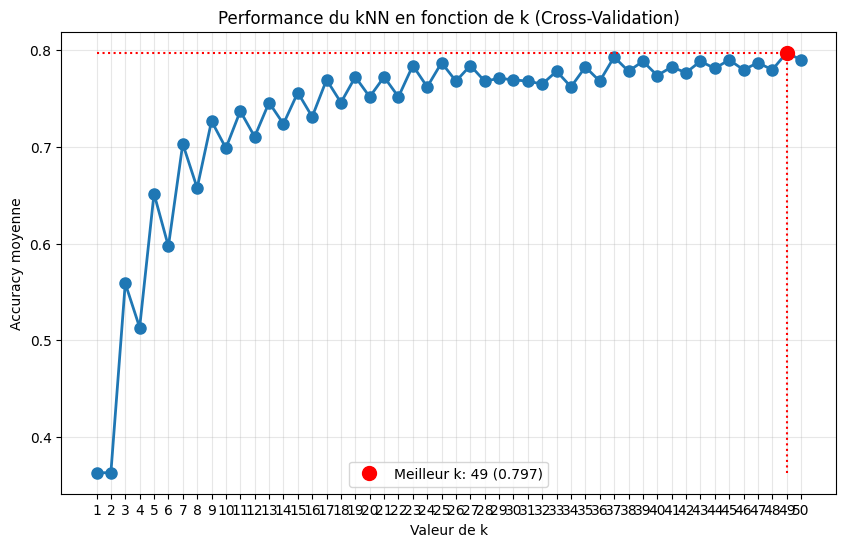

Accuracy finale sur le test set: 0.8118 (81.18%) avec k k={best_k}
Bayes optimal: 86%


In [70]:
X = pd.DataFrame(X_cleaned2)
y = pd.Series(y_cleaned2)

n = X_cleaned2.shape[0] * 4 // 5

X_train = X.iloc[:n]
y_train = y.iloc[:n]

X_test = X.iloc[n:]
y_test = y.iloc[n:]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

main_knn()

## Avec distances précalculées

In [95]:

def knn_algorithm_vectorise(p_indice, k, indices_train, D, y_np):
    """
    Args:
        p_indice : indice du point (numpy)
        k : nb voisins
        indices_train : indices des données d'entraînement 
        D : matrices des distances 
    """

    distances = D[p_indice, indices_train]  # distances du point test aux points d'entraînement
    k_indices = np.argsort(distances)[:k]
    k_nearest = [indices_train[i] for i in k_indices]
    votes = y_np[k_nearest].astype(int)
    return np.bincount(votes).argmax()


def evaluer_modele(X_np, y_np, indices_test, k, indices_train, D):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(indices_test)
    
    for i in indices_test:
        vrai_label = y_np[i]
        
        prediction = knn_algorithm_vectorise(i, k, indices_train, D, y_np)
        if prediction == vrai_label:
            nombre_correct += 1
    
    return nombre_correct / total


def cross_validation_knn(X_np, y_np, k_values, n_folds=5):
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = X_np.shape[0] // n_folds
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")

    # Calcul de toutes les distances 
    D = cdist(X_np, X_np, metric='euclidean')
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        indices_test = [i for i in range(val_start, val_end)]
        indices_train = [i for i in range(X_np.shape[0]) if i not in indices_test]
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_np, y_np, indices_test, k, indices_train, D)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies


def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


def main_knn(X_np, y_np):
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 100 + 1))
    n = X_np.shape[0] * 4 // 5

    # Séparation des données
    indices_train = [i for i in range(n)]
    indices_test = [i for i in range(n, len(X))]

    X_train = X_np[:n]
    y_train = y_np[:n]
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)

    indices_train = list(range(n))
    indices_test = list(range(n, len(X_np)))
    
    D = cdist(X_np, X_np, metric='euclidean')

    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_np, y_np, indices_test, best_k, indices_train, D)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + f" avec k k={best_k}")
    print(f"Bayes optimal: 86%")


def main_knn_exp(X_np, y_np):
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 100 + 1))
    n = X_np.shape[0] * 4 // 5

    # Séparation des données
    indices_train = [i for i in range(n)]
    indices_test = [i for i in range(n, len(X))]

    X_train = X_np[:n]
    y_train = y_np[:n]
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    #plot_results(mean_accuracies)

    indices_train = list(range(n))
    indices_test = list(range(n, len(X_np)))
    
    D = cdist(X_np, X_np, metric='euclidean')

    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_np, y_np, indices_test, best_k, indices_train, D)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + f" avec k k={best_k}")
    print(f"Bayes optimal: 86%")

    return (best_k, best_accuracy, mean_accuracies, final_accuracy)


Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 33, précision de 0.8595


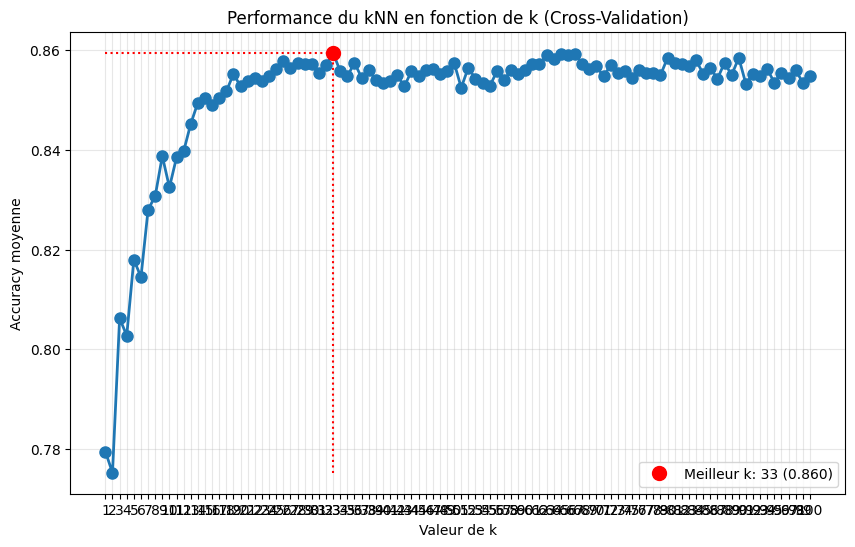

[4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 416

In [74]:
main_knn(X_np, y_np)

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.9475


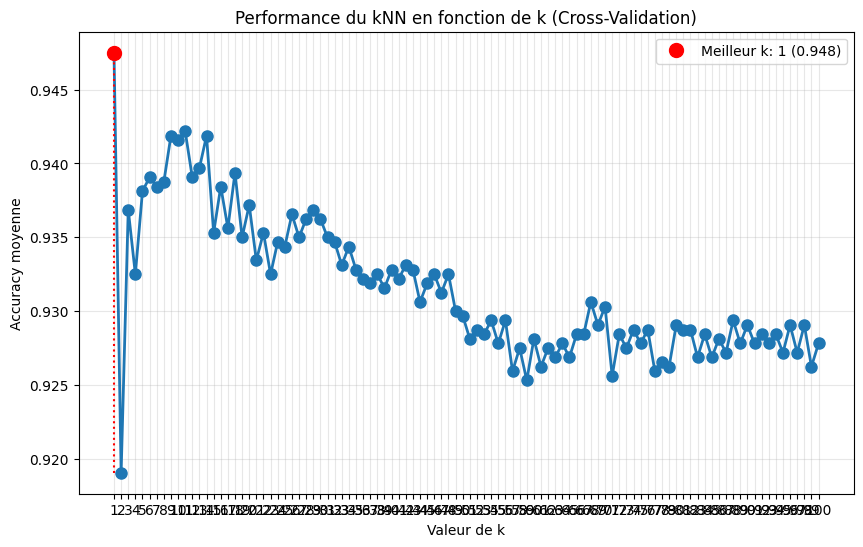

Accuracy finale sur le test set: 0.9526 (95.26%) avec k k=1
Bayes optimal: 86%


In [89]:
main_knn(X_cleaned, y_cleaned)

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 78, précision de 0.7941


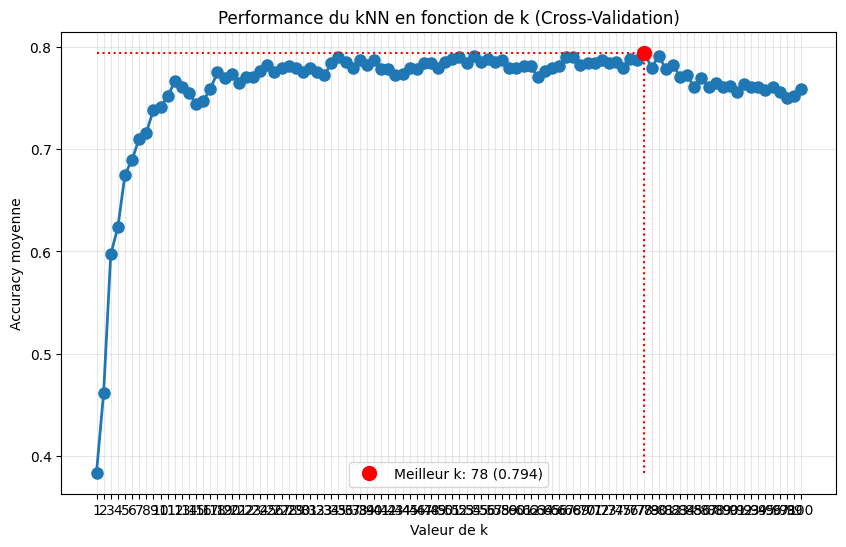

[680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39

In [73]:
main_knn(X_cleaned2, y_cleaned2)

In [ ]:

data_depart = np.concatenate((X_np, y_np.reshape(-1, 1)), axis=1)
data_reduction1 = np.concatenate((X_cleaned, y_cleaned.reshape(-1, 1)), axis=1)
data_reduction2 = np.concatenate((X_cleaned2, y_cleaned2.reshape(-1, 1)), axis=1)

exp_best_k = [[], [], []]
exp_best_accuracy = [[], [], []]
exp_mean_accuracies = [[], [], []]
exp_final_accuracy = [[], [], []]


N = 0
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 70, précision de 0.8630
Accuracy finale sur le test set: 0.8550 (85.50%) avec k k=70
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 8

In [134]:
nb_exp = 5

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    num = 0
    exp_data = data_depart.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y)
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    
    num = 1
    exp_data = data_reduction1.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y)
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    
    num = 2
    exp_data = data_reduction2.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y)
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)

print("FIN")


N = 1 / 5
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 80, précision de 0.8588
Accuracy finale sur le test set: 0.8670 (86.70%) avec k k=80
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 8

In [135]:
print(len(exp_best_accuracy[0]))
print(len(exp_best_k[0]))
print(len(exp_final_accuracy[0]))
print(len(exp_mean_accuracies[0]))

print(exp_best_k)

20
20
20
20
[[70, 34, 100, 83, 48, 60, 64, 76, 68, 74, 54, 90, 62, 62, 100, 80, 62, 84, 72, 100], [8, 10, 8, 10, 18, 10, 8, 7, 15, 22, 14, 12, 8, 12, 28, 7, 8, 8, 12, 12], [39, 73, 42, 62, 48, 87, 28, 60, 55, 76, 35, 78, 44, 62, 81, 95, 58, 33, 61, 41]]


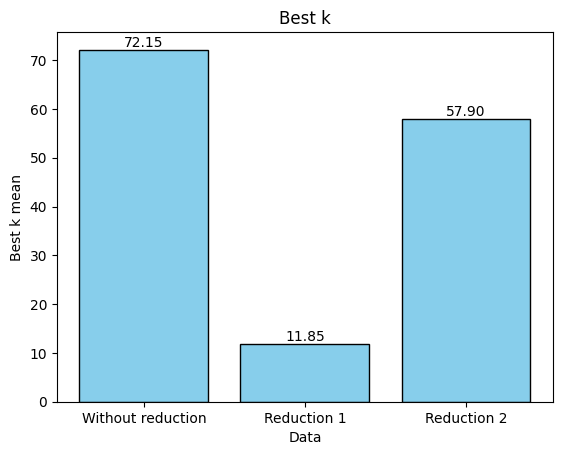

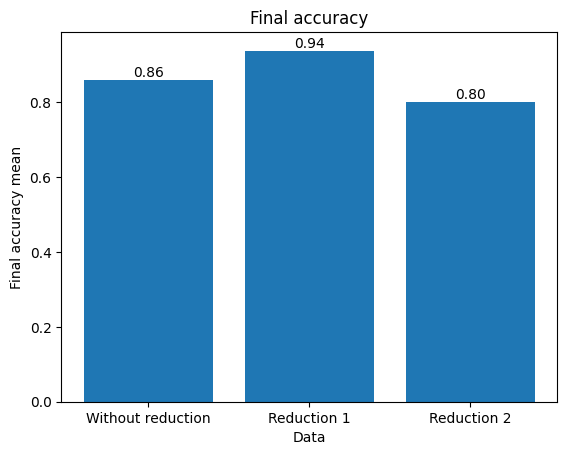

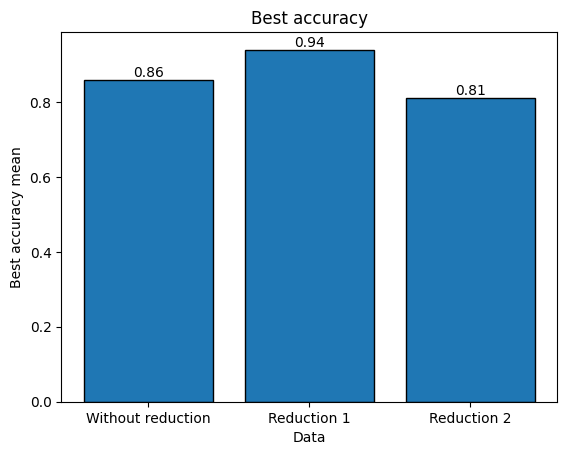

In [136]:
labels = ['Without reduction', 'Reduction 1', 'Reduction 2']

valeurs = [np.mean(np.array(exp_best_k[0])), np.mean(np.array(exp_best_k[1])), np.mean(np.array(exp_best_k[2]))]
plt.bar(labels, valeurs, color='skyblue', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best k")
plt.xlabel("Data")
plt.ylabel("Best k mean")

plt.show()

valeurs = [np.mean(np.array(exp_final_accuracy[0])), np.mean(np.array(exp_final_accuracy[1])), np.mean(np.array(exp_final_accuracy[2]))]
plt.bar(labels, valeurs)

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

y_max = max(valeurs)
plt.ylim(0, y_max + 0.05)

plt.title("Final accuracy")
plt.xlabel("Data")
plt.ylabel("Final accuracy mean")

plt.show()

valeurs = [np.mean(np.array(exp_best_accuracy[0])), np.mean(np.array(exp_best_accuracy[1])), np.mean(np.array(exp_best_accuracy[2]))]
plt.bar(labels, valeurs, edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best accuracy")
plt.xlabel("Data")
plt.ylabel("Best accuracy mean")

plt.show()

## Inégalitée triangulaire